# Causal Analysis of Sensor Dataset

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import scipy
import random
import seaborn as sns
from pymatch.Matcher import Matcher
from pymatch.functions import ks_boot
from joblib import Parallel, delayed

from utils import treatment_effect

sns.set_context("notebook")
%matplotlib inline

random.seed(0)
np.random.seed(0)

TREATMENT_COL = 'race'
treatment_subdimensions = []
TREATMENT_VAL = 'Black'

OUTCOME_NAME = 'prediction'

CONT_COVARIATES = ['age', 'educationnum', 'capitalgain', 'capitalloss', 'hoursperweek']

TREATMENT = 'T'
OUTCOME = 'O'

In [2]:
dataset = pd.read_csv('data/census-random-prediction.csv', index_col=0)
dataset['prediction'] = dataset['prediction'] == '>50K'
dataset.columns = dataset.columns.str.replace('-','')
dataset.head()

,age,workclass,education,educationnum,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,prediction
0,54,Local-gov,9th,14,Separated,Protective-serv,Wife,Black,Female,7298,2179,91,Taiwan,True
1,72,Never-worked,Masters,3,Married-spouse-absent,Sales,Unmarried,Black,Female,3781,1735,10,India,False
2,85,State-gov,11th,6,Married-AF-spouse,Armed-Forces,Other-relative,Black,Female,7443,2174,65,Laos,True
3,31,Federal-gov,Assoc-voc,11,Widowed,Handlers-cleaners,Unmarried,White,Male,4064,419,84,Peru,True
4,40,Local-gov,Doctorate,14,Separated,Sales,Unmarried,Black,Female,3781,1980,87,Dominican-Republic,True


In [3]:
# Introduce binary treatment column as proposed by Data X-Ray
dataset[TREATMENT] = dataset[TREATMENT_COL] == TREATMENT_VAL
dataset.rename({OUTCOME_NAME: OUTCOME}, axis=1, inplace=True)
dataset.head()

COVARIATES = dataset.drop([TREATMENT, OUTCOME, TREATMENT_COL] + treatment_subdimensions, axis=1).columns.values
CAT_COVARIATES = list(c for c in COVARIATES if c not in CONT_COVARIATES)

## Analysis with Matching and Propensity Score Stratification

In [4]:
dataset.columns
a=dataset[dataset['T']].copy()
b=dataset[~dataset['T']].iloc[:len(a)].copy()
dataset=pd.concat([a,b],ignore_index=True)

In [5]:
match_vars = []
att = treatment_effect.match_then_stratify(dataset, match_vars, TREATMENT, TREATMENT_COL, treatment_subdimensions,
                                           OUTCOME, CONT_COVARIATES, CAT_COVARIATES)
att

Formula:
T ~ age+workclass+education+educationnum+maritalstatus+occupation+relationship+sex+capitalgain+capitalloss+hoursperweek+nativecountry
n majority: 5042
n minority: 4958
Fitting Models on Balanced Samples: 1\50

C:\Users\Amnesix\DOCUME~1\KIT---~1\00-AUS~1\Studium\WINTER~1\CAUSAL~1\mldcpy\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Fitting Models on Balanced Samples: 50\50
Average Accuracy: 53.53%


-0.031422269751301725

#### Get statistical significance by comparing with placebo treatment

In [6]:
n_iter = 50

def generate_placebo_sample(placebo_data):
    placebo_data[TREATMENT] = np.random.randint(0, 2, len(placebo_data))
    return treatment_effect.match_then_stratify(placebo_data, match_vars, TREATMENT, TREATMENT_COL, treatment_subdimensions, 
                               OUTCOME, CONT_COVARIATES, CAT_COVARIATES, n_models=1)
placebo_results = Parallel(n_jobs=4)(delayed(generate_placebo_sample)(dataset.copy()) for _ in range(n_iter))

In [7]:
if (np.percentile(placebo_results, 2.5) <= att <= np.percentile(placebo_results, 97.5)):
    print('Treatment effect within 95%-bounds of placebo effect: {} <= {} <= {}'.format(np.percentile(placebo_results, 2.5), att, np.percentile(placebo_results, 97.5)))
else:
    print('Treatment effect outside 95%-bounds of placebo effect: {} not in [{}, {}]'.format(att, np.percentile(placebo_results, 2.5), np.percentile(placebo_results, 97.5)))

Treatment effect outside 95%-bounds of placebo effect: -0.031422269751301725 not in [-0.010415813980985372, 0.011382536920349995]


In [8]:
treatment_results = Parallel(n_jobs=4)(delayed(treatment_effect.match_then_stratify)(dataset.sample(frac=.7), match_vars, TREATMENT, TREATMENT_COL, 
                                                                                     treatment_subdimensions, OUTCOME, CONT_COVARIATES, CAT_COVARIATES, 
                                                                                     n_models=1) for _ in  range(n_iter))

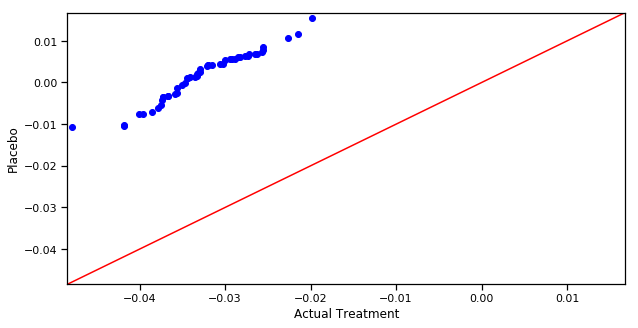

In [9]:
# QQ-Plot to compare empirical distributions. If straight line, no significant difference from placebo treatment.
from statsmodels.graphics.gofplots import qqplot_2samples
import pylab

qqplot_2samples(np.array(placebo_results), np.array(treatment_results), xlabel='Actual Treatment', ylabel='Placebo', line='45')
pylab.show()

In [10]:
alpha = .05
critical_value = np.sqrt(-np.log(alpha) / 2) * np.sqrt(2 * n_iter/(n_iter * n_iter))

ks_test = scipy.stats.ks_2samp(np.array(placebo_results), np.array(treatment_results))
if ks_test[0] > critical_value and ks_test[1] < alpha:
    print('Rejecting hypothesis that placebo treatment and actual treatment are of same distribution (K-S statistic: {}, p-value: {})'.format(ks_test[0], ks_test[1]))
else: 
    print('Cannot reject hypothesis that placebo and actual treatment are identical distribution (K-S statistic: {}, p-value: {})'.format(ks_test[0], ks_test[1]))

Rejecting hypothesis that placebo treatment and actual treatment are of same distribution (K-S statistic: 1.0, p-value: 2.16468817146063e-23)
